In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

In [2]:

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
warnings.filterwarnings("ignore")

C:\Users\kshar\AppData\Local\Temp\ipykernel_18312\3627220238.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


In [3]:
auto_data = pd.read_csv(r"C:\Users\kshar\myfiles\Datasets\Automobile_data.csv")
auto_data.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.4,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.4,8.0,115,5500,18,22,17450


In [4]:
X = auto_data.copy()
y = X.pop("price")

#label encoding for catagorical, 
for col in X.select_dtypes(["category","object"]):
    X[col], uniques = X[col].factorize()
y.replace(["?"], [0],inplace = True)    
# discrete_features = X.dtypes == int
discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]

In [5]:
#creat the model
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
def score_dataset(X, y, model=XGBRegressor()):
    # Label encoding for categoricals
    for colname in X.select_dtypes(["category", "object"]):
        X[colname], _ = X[colname].factorize()
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    score = cross_val_score(
        model, X, y, cv=5, scoring="neg_mean_squared_log_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score


<h1>MUTUAL INFORMATION<h1>

In [6]:
from sklearn.feature_selection import mutual_info_regression

In [7]:
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y)
mi_scores[::3]  # show a few features with their MI scores

curb-weight          1.385661
highway-mpg          0.931231
bore                 0.678089
length               0.564652
fuel-system          0.447302
drive-wheels         0.314944
compression-ratio    0.191790
body-style           0.056765
num-of-doors         0.005429
Name: MI Scores, dtype: float64

In [8]:
def plot_mi_scores(score):
    score = score.sort_values(ascending=True)
    width = np.arange(len(score))
    ticks = list(score.index)
    plt.barh(width,score)
    plt.yticks(width,ticks)
    plt.title("Mutual Information Scores")

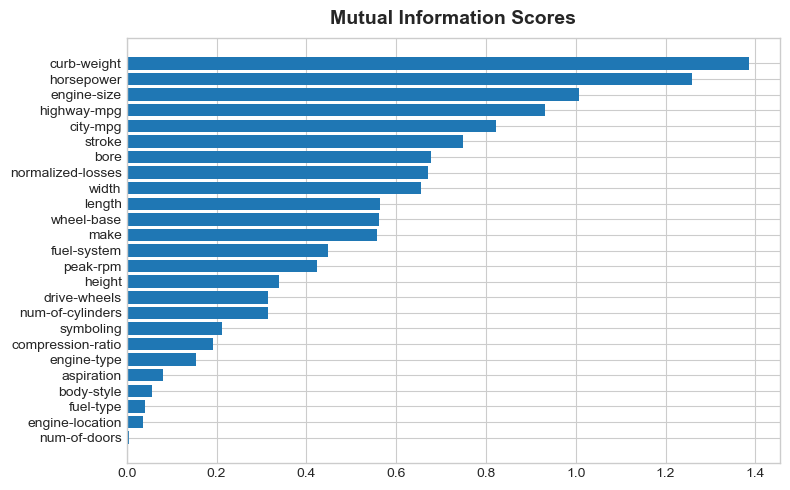

In [9]:
plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

In [10]:
#choose the features to scale 
features = ["curb-weight","horsepower","engine-size","highway-mpg","city-mpg"]

In [11]:
#standardization
X_scaled = X.loc[:,features]
# print(X_scaled)
X_scaled = (X_scaled - X_scaled.mean(axis = 0))/X_scaled.std(axis = 0)
# print(X_scaled)


<h1>CLUSTERING<h1>


In [12]:
from sklearn.cluster import KMeans

In [13]:
kmeans = KMeans(n_clusters = 10,n_init = 10,random_state = 0)


#Creat Cluster-Distance Features using "Fit_transform"
X_cd = kmeans.fit_transform(X_scaled)
# print(X_cd)
# Label features and join to dataset
X_cd = pd.DataFrame(X_cd, columns=[f"Centroid_{i}" for i in range(X_cd.shape[1])])
X = X.join(X_cd)
# print(X.columns)

In [14]:
score_dataset(X,y,model= XGBRegressor())

1.4066102294830567

In [15]:
# by adding cluster lebel

X["Cluster"] = kmeans.fit_predict(X_scaled)

In [16]:
score_dataset(X,y,model= XGBRegressor())

1.3888823493050453

<h1>PCA<h1>

PRINCIPLE COMPONENT ANALYSIS

In [17]:
from sklearn.decomposition import PCA

In [18]:
def apply_pca(X, standardize=True):
    # Standardize
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    # Create principal components
    pca = PCA()
    X_pca = pca.fit_transform(X)
    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return pca, X_pca, loadings

In [19]:
def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

# def make_mi_scores(X, y):
#     X = X.copy()
#     for colname in X.select_dtypes(["object", "category"]):
#         X[colname], _ = X[colname].factorize()
#     # All discrete features should now have integer dtypes
#     discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
#     mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
#     mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
#     mi_scores = mi_scores.sort_values(ascending=False)
#     return mi_scores



In [20]:
# print("Correlation with Price:\n")
# print(auto_data[features].corrwith(auto_data.price))

In [21]:
features = ["curb-weight","horsepower","engine-size","highway-mpg","city-mpg"]


In [22]:
pca, X_pca, loadings = apply_pca(X)
# print(X_pca.head())
# print(loadings.head())

In [ ]:
# auto_data.replace(["?"],[0],inplace = True)
# auto_data["make_encoded"] = auto_data.groupby("curb-weight")["price"].transform("mean")
# auto_data[["curb-weight","price","make_encoded"]].head()


<h1>Target Encoding<h1>

In [23]:
pip install category_encoders

Note: you may need to restart the kernel to use updated packages.


In [25]:

from category_encoders import MEstimateEncoder


In [28]:
auto_data.select_dtypes(["object"]).nunique()

normalized-losses     52
make                  22
fuel-type              2
aspiration             2
num-of-doors           3
body-style             5
drive-wheels           3
engine-location        2
engine-type            7
num-of-cylinders       7
fuel-system            8
bore                  39
stroke                37
horsepower            60
peak-rpm              24
price                187
dtype: int64

In [31]:
#encoding split
X_encode = auto_data.sample(frac = 0.20, random_state= 0)
y_encode = X_encode.pop("price")

#training_split
X_pretrain = auto_data.drop(X_encode.index)
y_train = X_pretrain.pop("price")

In [33]:
#creat a encoder instance, choose m to control noise
encoder = MEstimateEncoder(cols = ["horsepower"], m = 5.0)

#fit the encoder on to encoding split
encoder.fit(X_encode,y_encode)

#encode the 'horsepower' column to creat final training data
X_train = encoder.transform(X_pretrain,y_train)

TypeError: ufunc 'divide' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''